   # TORCH_exercise3   

* 头文件

In [2]:
import numpy as np
import torch.nn as nn
import torchvision
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from matplotlib import pyplot as plt

* 读取数据

In [3]:
transform = transforms.Compose([transforms.ToTensor()])   #转张量，归一化
 
#下载数据集
data_train = datasets.MNIST(root = './data/MNIST',
                            transform=transform,
                            train = True,
                            download = True)
 
data_test = datasets.MNIST(root='./data/MNIST',
                           transform = transform,
                           train = False,
                           download = True)


#装载数据
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 256,
                                                shuffle = True)
 
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 256,
                                               shuffle = True)

* 网络定义

In [4]:
class modle(nn.Module):
    def __init__(self):
        super(modle, self).__init__()   #继承父类初始化
        self.conv1 = nn.Sequential(
            nn.BatchNorm2d(1,affine=True),     #批标准化，通道数为1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),#输入通道，输出通道（特征），卷积块尺寸，步长，是否补齐（为1是大小不变）
            #输入1*28*28，输出64*28*28
            nn.BatchNorm2d(64,affine=True),     #批标准化，通道数为64
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                   #池化 输出64*14*14
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),#输入64*14*14，输出32*14*14
            
            nn.BatchNorm2d(32,affine=True),     #批标准化，通道数为32
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                   #池化 输出32*7*7
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1), #输入32*7*7，输出16*7*7

            nn.BatchNorm2d(16,affine=True),     #批标准化，通道数为32
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                   #池化 输出16*3*3
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16*3*3, 32),
            nn.Dropout(0.2)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(32, 10),
            nn.Softmax()
        )


    def forward(self,x):

        #print(x.size()) 
        x = self.conv1(x)
        #print(x.size())
        x = self.conv2(x)
        #print(x.size())
        x = self.conv3(x)
        #print(x.size())
        x = x.view(x.size()[0], -1)   # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        #print(x.size())
        x = self.fc1(x)
        x = self.fc2(x)
        #x = x.squeeze(-1)
        return x




In [9]:
if __name__ == "__main__":   
    device = torch.device('cuda:0')
    mymodel = modle().to(device)
    summary(mymodel, (1, 28, 28))    #显示模型结构
    epochs = 10
   # Loss and optimizer
    cost = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.RMSprop(mymodel.parameters(),lr=0.0001,alpha=0.99,eps=1e-08,weight_decay=0,momentum=0,
                                    centered=False)
    eval_ = {'cost': []}
    train_correct=0
    for epoch in range(epochs):
        sum_loss=0
        n = 0
        for data in data_loader_train:
            inputs,labels=data                     #inputs 维度
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = mymodel(inputs).to(device)              #得到预测值   
            
            loss = cost(outputs,labels).sum()#.to(device)    #数据集损失函数的值=每个样本的损失函数值的和。  
            optimizer.zero_grad()                  #对优化函数梯度清零
            loss.backward()                         # 计算损失对于各个参数的梯度
            optimizer.step()                       # 执行单步优化操作：更新参数
            sum_loss+=loss.item()
            n += labels.shape[0]
        print('批训练损失：',sum_loss / n)
        eval_['cost'].append(sum_loss / n)     #保存到字典
        
            # print(X.shape,y.shape) 
    mymodel.eval()
    
    #torch.save(model,"mlp.pkl")        #保存模型
    torch.save(mymodel.state_dict(), 'LSTM.pth')  #保存模型参数

C:\Anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 28, 28]               2
            Conv2d-2           [-1, 64, 28, 28]             640
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]          18,464
       BatchNorm2d-7           [-1, 32, 14, 14]              64
              ReLU-8           [-1, 32, 14, 14]               0
         MaxPool2d-9             [-1, 32, 7, 7]               0
           Conv2d-10             [-1, 16, 7, 7]           4,624
      BatchNorm2d-11             [-1, 16, 7, 7]              32
             ReLU-12             [-1, 16, 7, 7]               0
        MaxPool2d-13             [-1, 16, 3, 3]               0
           Linear-14                   

* 绘制损失曲线

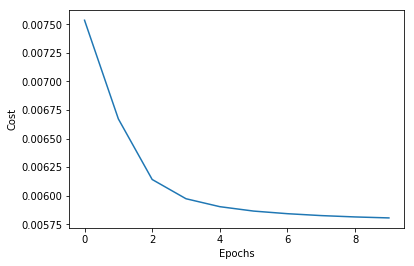

In [10]:
    plt.plot(range(epochs), eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    # plt.savefig('images/05_03.png', dpi=300)
    plt.show()

true:7, predict:[7]


C:\Anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


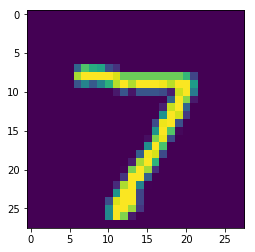

In [28]:
    img, label = data_test[0]
    inputs = img.unsqueeze(0).to(device)
    labels = label#.to(device)
    outputs = mymodel(inputs).to(device)              #得到预测值
    plt.imshow(img.squeeze(0))
    output = torch.argmax(outputs,1)
    print(f"true:{labels}, predict:{output.cuda().cpu().numpy()}")